# Task: Temporal Social Network Embedding (3-Way Tensor Decomposition) 

In [1]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## step 1. load the data

In [2]:
idfile = os.path.join('data','ids.txt')
netfile = os.path.join('data','primaryschool.csv')

component_actual = []
people_class = dict()
interacts = dict()
people_ids = dict()
ids_people = dict()
with open(idfile, 'r') as idr, open(netfile, 'r') as netr:
    for line in idr:
        params = line.split()
        if params[0] not in people_ids:
            people_class[len(people_ids)] = params[1]
            ids_people[len(people_ids)] = params[0]
            people_ids[params[0]] = len(people_ids)
            component_actual.append(params[1])
        
    spamreader = csv.reader(netr)
    for row in spamreader:
        items = row[0].split('\t')
        if int(items[0]) not in interacts.keys():
            interacts[int(items[0])] = [(items[1],items[2])]
        else:
            interacts[int(items[0])].append((items[1],items[2]))

num_node = len(component_actual)

## step 2. construct the 3-way tensor

tensor size: (242, 242, 150)


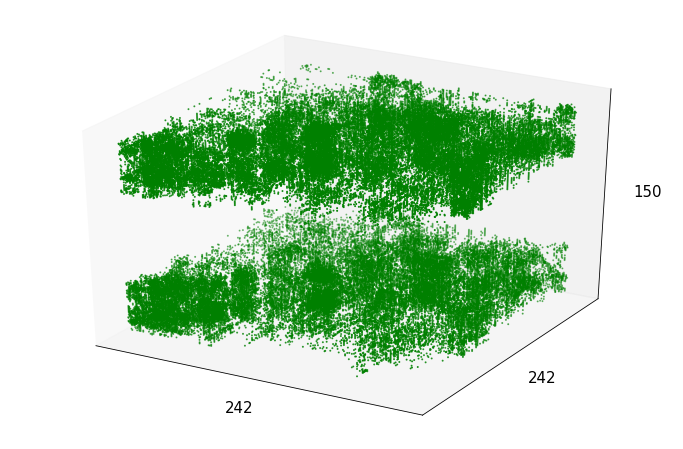

In [3]:
num_layer = 150
duration = 13 # all people build links if they have interations within each 13-mins interval
start_time = list(interacts.keys())[0]
tensor = []
for i in range(num_layer):
    base_net = np.zeros([num_node,num_node])   
    end_time = start_time + duration * 60
    for time in interacts.keys():
        if time in range(start_time, end_time):
            for link in interacts[time]:
                node_i = people_ids[link[0]]
                node_j = people_ids[link[1]]
                base_net[node_i,node_j] = 1
                base_net[node_j,node_i] = 1
    tensor.append(base_net)
    start_time = end_time
tensor = np.array(tensor)
tensor_T = np.transpose(tensor,[2,1,0])
print('tensor size:',tensor_T.shape)
x,y,z = tensor_T.nonzero()
fig = plt.figure(figsize=(12,8))
fig.clf()
ax = fig.add_subplot(111, projection='3d')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel(tensor_T.shape[0], fontsize=15)
ax.set_ylabel(tensor_T.shape[1], fontsize=15)
ax.set_zlabel(tensor_T.shape[2], fontsize=15)
ax.scatter(x, y, z, s=1, c= 'green')

In [4]:
# from mayavi import mlab
# mlab.contour3d(tensor)
# mlab.outline()
# mlab.show()

## step 3. tensor decomposition (non_negative_parafac)

In [5]:
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
num_component = 13
print('tensor{}'.format(tensor.shape),'= component_1 + component_2 + ... + component_{}= [A,B,C]'.format(num_component))
weights, factors = non_negative_parafac(tl.tensor(tensor, dtype=tl.float32), rank=num_component)

tensor(150, 242, 242) = component_1 + component_2 + ... + component_13= [A,B,C]


In [6]:
C = np.array(factors[0])
A = np.array(factors[1])
B = np.array(factors[2])
print('[A,B,C]:', A.shape, B.shape, C.shape)

[A,B,C]: (242, 13) (242, 13) (150, 13)


## step 4. visualization and interpretation

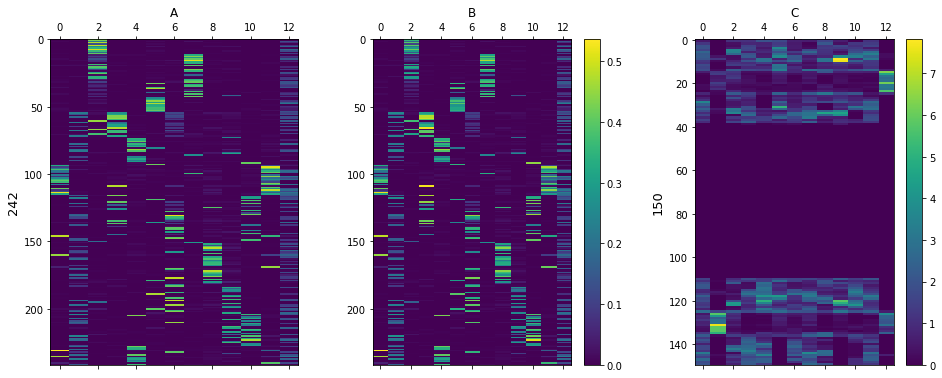

In [7]:
fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(hspace=0, wspace=0.3)

ax1 = fig.add_subplot(131)
ax1.matshow(A)
ax1.set_aspect('auto')
ax1.set_title('A')
ax1.set_ylabel(tensor.shape[1], size=(13))

ax2 = fig.add_subplot(132)
cax = ax2.matshow(B)
ax2.set_aspect('auto')
ax2.set_title('B')
fig.colorbar(cax)

ax3 = fig.add_subplot(133)
cax = ax3.matshow(C)
ax3.set_aspect('auto')
ax3.set_title('C')
ax3.set_ylabel(tensor.shape[0], size=(13))

fig.colorbar(cax)

#### Conclusion:
1. Factor matrice A and B explain the community/calss, where each latent factor represents a community/class. Students from the same class at school have higher membership value to the same latent factor. <br> <br>

2. Factor matrix C implies the temporal activity of each community/class/component.

## Step 5. verify components derived from the factor matrix A

In [8]:
component_preds = A.argmax(axis=1) # classify nodes into respective components based on the largest membership values
print('{} nodes in total, each node belongs to a predicted component with the largest membership value:\n\n'.format(A.shape[0]), component_preds)

print('\nthe actual components/classes for all {} nodes: \n\n'.format(A.shape[0]), component_actual)

242 nodes in total, each node belongs to a predicted component with the largest membership value:

 [ 2  2  2  2  2  2  2  2  2  2  2  2  7  7  7  7  7  7  7  2  7  2  2  7
  7  2  2  7  2  2  7  7  7  5  7  7  5  5  2  7  5  7  9  7  5  5  5  5
  5  5  5  5  5  5  5  3  3  3  3  3  3  2  1  3  3  3  3  2  3  3  2  2
  3  9  4  4  4  4  4  4  4  5  4  4  9  9  7  4  4  4  4  4 10  5  0 11
 11  0 11 11  7  0 11  0  0  0  0 11 11  3 11  0 11 11  0  0  3 10 10  5
 10  3 10  3 10  8  3 10  6 10 10  6  6  6  6  3  5  3 10  3  6  6 10  6
 10  3  0  6  6 10  2  7  8  8  8  8  8  8  6  8  0  8  8  8  8  8  8  8
  8 11  6  6  8  8  8  8  8  6  8  5  8  8  6  6  9  9  9  9  6  5  9  9
  6  9  6  2  9  6  9  9  5  6  6  9 10  4 10 10  9 10  6 10 10  9  9 10
 10  9 10  9 10  9 10 10  9  9 10 10  4  4  4  0  6  9  4  0  4  4  4  4
 11  4]

the actual components/classes for all 242 nodes: 

 ['5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5A', '5A', '5A', '5A', '5A', '5A', 

In [9]:
# matches = dict({'5B':2, '5A':7, '4A':5, '3B':3, '2A':4, '1B':11, '2B':10, '3A':6, '1A':8, '4B':9, 'Teachers':1})
matches = dict({2:'5B', 7:'5A', 5:'4A', 3:'3B', 4:'2A', 11:'1B', 10:'2B', 6:'3A', 8:'1A', 9:'4B', 0:'Teachers', 1:'Others'})
A_mapped = [matches[v] for v in component_preds]
print('{} nodes in total, each node belongs to a predicted component with the largest membership value:\n\n'.format(A.shape[0]), A_mapped)

242 nodes in total, each node belongs to a predicted component with the largest membership value:

 ['5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5A', '5A', '5A', '5A', '5A', '5A', '5A', '5B', '5A', '5B', '5B', '5A', '5A', '5B', '5B', '5A', '5B', '5B', '5A', '5A', '5A', '4A', '5A', '5A', '4A', '4A', '5B', '5A', '4A', '5A', '4B', '5A', '4A', '4A', '4A', '4A', '4A', '4A', '4A', '4A', '4A', '4A', '4A', '3B', '3B', '3B', '3B', '3B', '3B', '5B', 'Others', '3B', '3B', '3B', '3B', '5B', '3B', '3B', '5B', '5B', '3B', '4B', '2A', '2A', '2A', '2A', '2A', '2A', '2A', '4A', '2A', '2A', '4B', '4B', '5A', '2A', '2A', '2A', '2A', '2A', '2B', '4A', 'Teachers', '1B', '1B', 'Teachers', '1B', '1B', '5A', 'Teachers', '1B', 'Teachers', 'Teachers', 'Teachers', 'Teachers', '1B', '1B', '3B', '1B', 'Teachers', '1B', '1B', 'Teachers', 'Teachers', '3B', '2B', '2B', '4A', '2B', '3B', '2B', '3B', '2B', '1A', '3B', '2B', '3A', '2B', '2B', '3A', '3A', '3A', '3A', '3B', '4A', '3B', '2B', '

In [10]:
component_labels = dict({2:'5B', 7:'5A', 5:'4A', 3:'3B', 4:'2A', 11:'1B', 10:'2B', 6:'3A', 8:'1A', 9:'4B', 0:'None1', 1:'None2', 12:'None3'})
people_class_ranked = {k: v for k, v in sorted(people_class.items(), key=lambda item: item[1])}
ids_ranked = list(people_class_ranked.keys())
print(people_class_ranked)

{125: '1A', 152: '1A', 154: '1A', 155: '1A', 156: '1A', 157: '1A', 159: '1A', 161: '1A', 162: '1A', 163: '1A', 164: '1A', 165: '1A', 166: '1A', 167: '1A', 168: '1A', 172: '1A', 173: '1A', 174: '1A', 175: '1A', 176: '1A', 178: '1A', 180: '1A', 181: '1A', 94: '1B', 95: '1B', 96: '1B', 97: '1B', 98: '1B', 99: '1B', 101: '1B', 102: '1B', 103: '1B', 104: '1B', 105: '1B', 106: '1B', 107: '1B', 108: '1B', 110: '1B', 111: '1B', 112: '1B', 113: '1B', 114: '1B', 115: '1B', 160: '1B', 169: '1B', 231: '1B', 235: '1B', 240: '1B', 74: '2A', 75: '2A', 76: '2A', 77: '2A', 78: '2A', 79: '2A', 80: '2A', 82: '2A', 83: '2A', 87: '2A', 88: '2A', 89: '2A', 90: '2A', 91: '2A', 228: '2A', 229: '2A', 230: '2A', 234: '2A', 236: '2A', 237: '2A', 238: '2A', 239: '2A', 241: '2A', 117: '2B', 118: '2B', 120: '2B', 122: '2B', 124: '2B', 127: '2B', 129: '2B', 130: '2B', 138: '2B', 142: '2B', 144: '2B', 149: '2B', 204: '2B', 206: '2B', 207: '2B', 209: '2B', 211: '2B', 212: '2B', 215: '2B', 216: '2B', 218: '2B', 220: '2

10 components are detected:


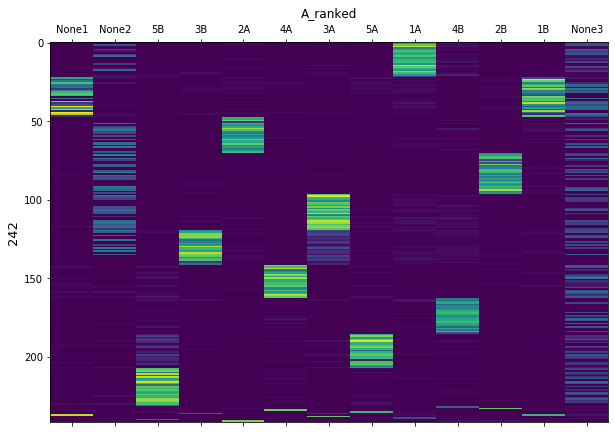

In [11]:
A_ranked = A[ids_ranked]

fig = plt.figure(figsize=(10,7))
# fig.subplots_adjust(hspace=0, wspace=0.3)
ax = fig.add_subplot(111)
ax.matshow(A_ranked)
ax.set_aspect('auto')
ax.set_title('A_ranked')
ax.set_ylabel(tensor.shape[1], size=(13))
ax.set_xticks(range(0,13))
ax.set_xticklabels([component_labels[0],component_labels[1],component_labels[2],
                    component_labels[3],component_labels[4],component_labels[5],
                    component_labels[6],component_labels[7],component_labels[8],
                    component_labels[9],component_labels[10],component_labels[11], component_labels[12]])
print('10 components are detected:')

overall classification accuracy = 0.9008264462809917

[[24  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 21  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  0  0  0  0  0  0  1]
 [ 0  0  0  0 23  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0 13  0]
 [ 0  0  0  0  0  0 26  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 23  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 23  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 23  0  0]
 [ 1  1  1  1  1  0  1  1  1  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]


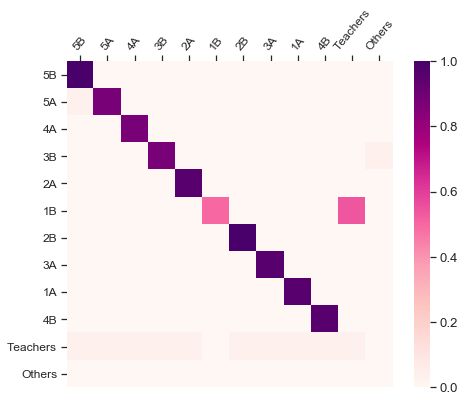

In [12]:
predict = A_mapped
actual = component_actual
labs = list(matches.values())

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
sns.set(style="white")

classification_accuracy = accuracy_score(actual, predict)
print('overall classification accuracy = {}\n'.format(classification_accuracy))
mat = confusion_matrix(actual, predict, labels=labs)
print(mat)

x = mat / 24
y= labs

plt.figure(figsize=(7.5, 6))
sns.set(font_scale=1.2)
ax = sns.heatmap(x, annot=False, vmin=0, vmax=1, square=True, xticklabels=y, yticklabels=y, cmap='RdPu')

ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.set_xticklabels(y, fontsize=12)
ax.set_yticklabels(y, fontsize=12)
plt.yticks(rotation=0) 
plt.xticks(rotation=50) 
plt.show()

-------------------------------------------------------------------------------------

# Method 2: Probabilistic Topic Model (LDA)

### Implementation Steps:
1. Construct the training corpus, where each student (or teacher) is analogical to a document. 
2. Learn topic distribution of each document based on LDA
3. Explain the results with latent topics

## Step 1. construct documents from the multi-layer social network

In [13]:
print(tensor.shape)
corpus = np.sum(tensor, axis=0)
print(corpus.shape)
print(corpus[0])

(150, 242, 242)
(242, 242)
[ 0. 12. 16. 18.  7. 14.  7.  9. 18. 11.  6. 24.  1.  7.  0.  3.  2.  4.
  0.  8. 11. 15.  7.  5.  0. 10. 14.  2. 20.  4.  2.  0. 13.  2.  3.  4.
  0.  0.  3.  2.  0.  8.  0.  4.  0.  2.  3.  1.  4.  0.  0.  1.  0.  2.
  0.  2.  1.  0.  1.  0.  0. 15.  1.  0.  0.  0.  1. 13.  0.  0. 20. 13.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  9.  0.  0.  1.  1.  1.  0.  0.  4.  0.  0.  0.  0.  0.
  4.  0.  0.  0.  2.  1.  0.  1.  2.  0.  0.  2.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  2.  7.  2.  0.  0.  0.  0.  0.  2.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  1.  0.  0.  0.  0.  0.  3.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 12.  0.  2.
  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.

In [14]:
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

docs = [' '.join(list(chain.from_iterable(map(lambda x: int(x[1])*['w'+str(x[0])], enumerate(vec))))) for vec in corpus]
print(docs[0])

count_vect = CountVectorizer()
doc_term_matrix = count_vect.fit_transform(docs)

# print(doc_term_matrix.toarray()[0])


LDA = LatentDirichletAllocation(n_components=13, random_state=42, max_doc_update_iter=10000, max_iter=50)
LDA.fit(doc_term_matrix)

w1 w1 w1 w1 w1 w1 w1 w1 w1 w1 w1 w1 w2 w2 w2 w2 w2 w2 w2 w2 w2 w2 w2 w2 w2 w2 w2 w2 w3 w3 w3 w3 w3 w3 w3 w3 w3 w3 w3 w3 w3 w3 w3 w3 w3 w3 w4 w4 w4 w4 w4 w4 w4 w5 w5 w5 w5 w5 w5 w5 w5 w5 w5 w5 w5 w5 w5 w6 w6 w6 w6 w6 w6 w6 w7 w7 w7 w7 w7 w7 w7 w7 w7 w8 w8 w8 w8 w8 w8 w8 w8 w8 w8 w8 w8 w8 w8 w8 w8 w8 w8 w9 w9 w9 w9 w9 w9 w9 w9 w9 w9 w9 w10 w10 w10 w10 w10 w10 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w11 w12 w13 w13 w13 w13 w13 w13 w13 w15 w15 w15 w16 w16 w17 w17 w17 w17 w19 w19 w19 w19 w19 w19 w19 w19 w20 w20 w20 w20 w20 w20 w20 w20 w20 w20 w20 w21 w21 w21 w21 w21 w21 w21 w21 w21 w21 w21 w21 w21 w21 w21 w22 w22 w22 w22 w22 w22 w22 w23 w23 w23 w23 w23 w25 w25 w25 w25 w25 w25 w25 w25 w25 w25 w26 w26 w26 w26 w26 w26 w26 w26 w26 w26 w26 w26 w26 w26 w27 w27 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w28 w29 w29 w29 w29 w30 w30 w32 w32 w32 w32 w32 w32 w32 w32 w32 w32 w32 w32 w32 w33 w33 w34 w34 w34 w35 w35 w35 

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=10000, max_iter=50,
                          mean_change_tol=0.001, n_components=13, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [15]:
import pandas as pd

doc_topic_dist = LDA.transform(doc_term_matrix)


# column names
topicnames = ['topic' + str(i) for i in range(LDA.n_components)]
# index names
docnames = ['doc' + str(i) for i in range(len(docs))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(doc_topic_dist, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['assignment'] = dominant_topic
# Styling
def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

Topic probability distribution for all 242 nodes:


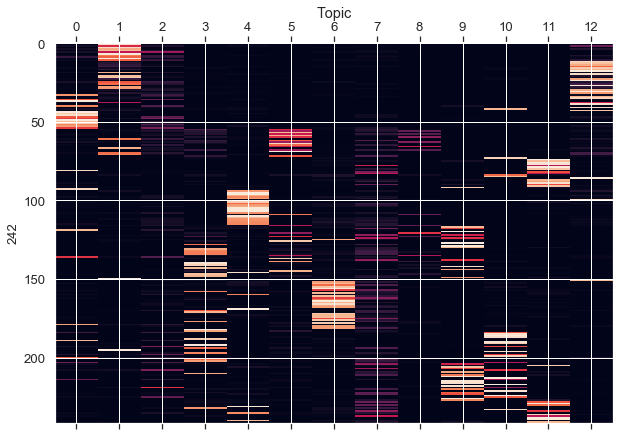

In [16]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.matshow(doc_topic_dist)
ax.set_aspect('auto')
ax.set_title('Topic')
ax.set_ylabel(tensor.shape[1], size=(13))
ax.set_xticks(range(0,13))
print('Topic probability distribution for all {} nodes:'.format(doc_topic_dist.shape[0]))

## Step 2. verify components derived from the document-topic matrix

In [17]:
LDA_preds = doc_topic_dist.argmax(axis=1) # classify nodes into respective components based on the largest membership values
print('{} nodes in total, each node belongs to a predicted component with the largest membership value:\n\n'.format(doc_topic_dist.shape[0]), LDA_preds)

print('\nthe actual components/classes for all {} nodes: \n\n'.format(doc_topic_dist.shape[0]), component_actual)

242 nodes in total, each node belongs to a predicted component with the largest membership value:

 [ 1  1  1  1  1  1  1  1  1  1  1  1 12 12 12 12 12 12 12  1 12  1  1 12
 12  1  1 12  1  1 12 12 12  0 12 12  0  0 12 12  0 12 10 12  0  0  0  0
  0  0  0  0  0  0  0  5  5  5  5  5  5  1  5  5  5  5  5  1  5  5  1  1
  5 10 11 11 11 11  7 11 11  0 11  7 10 10 12 11 11 11 11 11  9  0  4  4
  4  4  4  4 12  4  4  4  4  4  4  4  4  5  4  4  4  4  4  4  5  9  9  0
  9  8  9  5  9  6  5  9  3  9  9  3  3  3  3  5  0  5  9  5  3  3  9  3
  9  5  4  3  3  9  1 12  6  6  6  6  6  6  3  6  4  6  6  6  6  6  6  6
  6  4  3  3  6  6  6  6  6  3  6  0  6  6  3  3 10 10 10 10  3  0 10 10
  3 10  3  1 10  3 10 10  0  3  3 10  9 11  9  9 10  9  3  9  9 10 10  9
  9 10  9  2  9 10  9  9 10 10  9  9 11 11 11  4  3 10 11  4 11  7 11 11
  4 11]

the actual components/classes for all 242 nodes: 

 ['5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5A', '5A', '5A', '5A', '5A', '5A', 

In [18]:
LDA_matches = dict({1:'5B', 12:'5A', 0:'4A', 5:'3B', 11:'2A', 4:'1B', 9:'2B', 3:'3A', 6:'1A', 10:'4B', 7:'Teachers', 2:'Others_1', 8:'Others_2'})
LDA_preds_mapped = [LDA_matches[v] for v in LDA_preds]
print('{} nodes in total, each node belongs to a predicted component with the largest membership value:\n\n'.format(doc_topic_dist.shape[0]), LDA_preds_mapped)

242 nodes in total, each node belongs to a predicted component with the largest membership value:

 ['5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5B', '5A', '5A', '5A', '5A', '5A', '5A', '5A', '5B', '5A', '5B', '5B', '5A', '5A', '5B', '5B', '5A', '5B', '5B', '5A', '5A', '5A', '4A', '5A', '5A', '4A', '4A', '5A', '5A', '4A', '5A', '4B', '5A', '4A', '4A', '4A', '4A', '4A', '4A', '4A', '4A', '4A', '4A', '4A', '3B', '3B', '3B', '3B', '3B', '3B', '5B', '3B', '3B', '3B', '3B', '3B', '5B', '3B', '3B', '5B', '5B', '3B', '4B', '2A', '2A', '2A', '2A', 'Teachers', '2A', '2A', '4A', '2A', 'Teachers', '4B', '4B', '5A', '2A', '2A', '2A', '2A', '2A', '2B', '4A', '1B', '1B', '1B', '1B', '1B', '1B', '5A', '1B', '1B', '1B', '1B', '1B', '1B', '1B', '1B', '3B', '1B', '1B', '1B', '1B', '1B', '1B', '3B', '2B', '2B', '4A', '2B', 'Others_2', '2B', '3B', '2B', '1A', '3B', '2B', '3A', '2B', '2B', '3A', '3A', '3A', '3A', '3B', '4A', '3B', '2B', '3B', '3A', '3A', '2B', '3A', '2B', '3B', '1B',

In [19]:
LDA_component_labels = dict({1:'5B', 12:'5A', 0:'4A', 5:'3B', 11:'2A', 4:'1B', 9:'2B', 3:'3A', 6:'1A', 10:'4B', 7:'Teachers', 2:'Others_1', 8:'Others_2'})
# people_class_ranked = {k: v for k, v in sorted(people_class.items(), key=lambda item: item[1])}
# ids_ranked = list(people_class_ranked.keys())
# print(people_class_ranked)
doc_topic_dist_ranked = doc_topic_dist[ids_ranked]

Topic probability distribution for all 242 nodes:


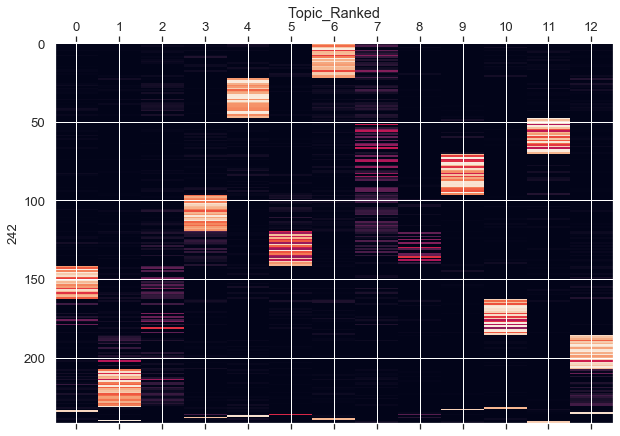

In [20]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.matshow(doc_topic_dist_ranked)
ax.set_aspect('auto')
ax.set_title('Topic_Ranked')
ax.set_ylabel(tensor.shape[1], size=(13))
ax.set_xticks(range(0,13))
print('Topic probability distribution for all {} nodes:'.format(doc_topic_dist.shape[0]))

overall classification accuracy = 0.9380165289256198

[[24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0 20  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 26  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 23  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 23  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 22  0  1  0]
 [ 1  1  1  1  1  1  1  1  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]]


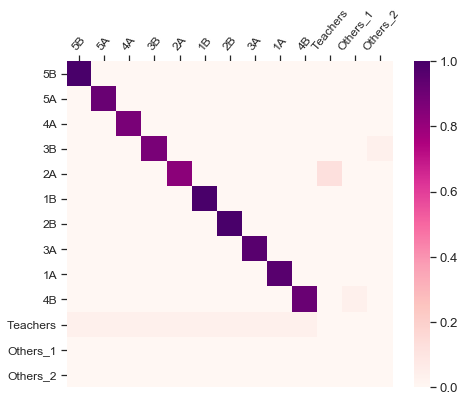

In [21]:
lda_predict = LDA_preds_mapped
lda_actual = component_actual
lda_labs = list(LDA_component_labels.values())

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
sns.set(style="white")

lda_classification_accuracy = accuracy_score(lda_actual, lda_predict)
print('overall classification accuracy = {}\n'.format(lda_classification_accuracy))
mat = confusion_matrix(lda_actual, lda_predict, labels=lda_labs)
print(mat)

x = mat / 24
y= lda_labs

plt.figure(figsize=(7.5, 6))
sns.set(font_scale=1.2)
ax = sns.heatmap(x, annot=False, vmin=0, vmax=1, square=True, xticklabels=y, yticklabels=y, cmap='RdPu')

ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.set_xticklabels(y, fontsize=12)
ax.set_yticklabels(y, fontsize=12)
plt.yticks(rotation=0) 
plt.xticks(rotation=50) 
plt.show()

# Conclusion. comparative results (classification accuracy)

In [22]:
print('3D Tensor Decomposition:', '{:.5f}\n'.format(classification_accuracy),
      'Topic Model (LDA):', '{:.5f}'.format(lda_classification_accuracy))

3D Tensor Decomposition: 0.90083
 Topic Model (LDA): 0.93802
